In [1]:
from imutils import paths
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pytorch_lightning as pl
# Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [2]:
DATASET_PATH = './data/caltech101/101_ObjectCategories'
CHECKPOINT_PATH = './saved_models/'
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# set device to GPU if CUDA is available
if use_cuda:
    device = torch.device('cuda:0') 
else:
    device = torch.device('cpu')

print('Device:', device)
print('Number of workers:', NUM_WORKERS)

Device: cuda:0
Number of workers: 24


In [3]:
# Download Caltech101 dataset
dataset_caltech101 = datasets.Caltech101(root=DATASET_PATH, download=True)

Files already downloaded and verified


In [4]:
image_paths = list(paths.list_images(DATASET_PATH))

data =  []
classes = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    classes.append(label)

data = np.array(data, dtype=object)
classes = np.array(classes, dtype=object)

In [6]:
# One hot encode
lb = LabelBinarizer()
classes = lb.fit_transform(classes)
print(f'Total number of classes: {len(lb.classes_)}')

Total number of classes: 101


In [7]:
# Divide the data into train (60%), validation (20%), and test (20%) set
(X, x_test , Y, y_test) = train_test_split(data, classes, test_size=0.2, stratify=classes, random_state=42)
(x_train, x_valid, y_train, y_valid) = train_test_split(X, Y, test_size=0.25, random_state=42)
print(f'x_train examples: {x_train.shape}\nx_valid examples: {x_valid.shape}\nx_test examples: {x_test.shape}')

x_train examples: (5205,)
x_valid examples: (1736,)
x_test examples: (1736,)


In [8]:
# Custom image dataset
class ImageDataset(Dataset):
    def __init__(self, images, classes=None, transforms=None):
        self.X = images
        self.classes = classes
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.classes is not None:
            return (data, self.classes[i])
        else:
            return data

In [9]:
# Custom transformation
class Transformation(object):

    def __init__(self, transforms):
        self.transforms = transforms
        self.n_views = 2

    def __call__(self, x):
        return [self.transforms(x) for i in range(self.n_views)]

In [10]:
# Define transforms
train_transforms = transforms.Compose([transforms.ToPILImage(), # Convert to PIL Image first
                                       transforms.RandomHorizontalFlip(), # Random horizontal flip
                                       transforms.Resize((224, 224)), # Resize the image in 200 X 200 before cropping
                                       transforms.RandomResizedCrop(96), # Random crop with size of 96 X 96
                                       transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), # Random color jitter
                                       transforms.RandomGrayscale(p=0.2), # Random gray scale
                                       transforms.GaussianBlur(kernel_size=9), # Apply Gaussian blur
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # Data normalization 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.ToPILImage(), # Convert to PIL Image first
                                       transforms.Resize((224, 224)), # Resize the image in 200 X 200 before cropping
                                       transforms.RandomResizedCrop(96), # Random crop with size of 96 X 96
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # Data normalization
                                                           [0.229, 0.224, 0.225])])

In [11]:
train_data = ImageDataset(x_train, y_train, Transformation(train_transforms))
valid_data = ImageDataset(x_valid, y_valid, Transformation(valid_transforms))
test_data = ImageDataset(x_test, y_test, Transformation(valid_transforms))

train_data[0]

([tensor([[[-0.4568, -0.9363, -1.0219,  ...,  2.1633,  2.0777,  1.7523],
           [-0.7137, -1.1075, -1.0219,  ...,  2.0092,  2.0605,  1.7523],
           [-0.9534, -0.7993, -0.5938,  ...,  2.0605,  1.9407,  1.6153],
           ...,
           [-0.6109, -0.6794, -0.5938,  ...,  1.7694,  1.6667,  0.5022],
           [-0.4911, -0.6794, -0.6281,  ...,  2.2147,  1.4269, -0.0287],
           [-0.8507, -0.8849, -0.6623,  ...,  2.2489,  1.0673, -0.3541]],
  
          [[ 0.6779,  0.1877, -0.0224,  ...,  2.4286,  2.4286,  2.1310],
           [ 0.4678,  0.1176,  0.0476,  ...,  2.4286,  2.4286,  2.1134],
           [ 0.3102,  0.5378,  0.5903,  ...,  2.4286,  2.3936,  2.0084],
           ...,
           [ 0.5553,  0.5028,  0.6429,  ...,  2.2360,  1.9209,  1.0630],
           [ 0.6604,  0.5028,  0.6078,  ...,  2.4286,  1.7458,  0.7129],
           [ 0.3803,  0.3627,  0.5553,  ...,  2.4286,  1.4657,  0.4853]],
  
          [[-0.2707, -0.7413, -0.8458,  ...,  1.2805,  1.3154,  0.9145],
           

In [12]:
import json
l_dict = { k + 1:v for k, v in enumerate(lb.classes_) }

with open('cat_to_name.json', 'w') as outfile:
    json.dump(l_dict, outfile)

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name


{'1': 'Faces',
 '2': 'Faces_easy',
 '3': 'Leopards',
 '4': 'Motorbikes',
 '5': 'accordion',
 '6': 'airplanes',
 '7': 'anchor',
 '8': 'ant',
 '9': 'barrel',
 '10': 'bass',
 '11': 'beaver',
 '12': 'binocular',
 '13': 'bonsai',
 '14': 'brain',
 '15': 'brontosaurus',
 '16': 'buddha',
 '17': 'butterfly',
 '18': 'camera',
 '19': 'cannon',
 '20': 'car_side',
 '21': 'ceiling_fan',
 '22': 'cellphone',
 '23': 'chair',
 '24': 'chandelier',
 '25': 'cougar_body',
 '26': 'cougar_face',
 '27': 'crab',
 '28': 'crayfish',
 '29': 'crocodile',
 '30': 'crocodile_head',
 '31': 'cup',
 '32': 'dalmatian',
 '33': 'dollar_bill',
 '34': 'dolphin',
 '35': 'dragonfly',
 '36': 'electric_guitar',
 '37': 'elephant',
 '38': 'emu',
 '39': 'euphonium',
 '40': 'ewer',
 '41': 'ferry',
 '42': 'flamingo',
 '43': 'flamingo_head',
 '44': 'garfield',
 '45': 'gerenuk',
 '46': 'gramophone',
 '47': 'grand_piano',
 '48': 'hawksbill',
 '49': 'headphone',
 '50': 'hedgehog',
 '51': 'helicopter',
 '52': 'ibis',
 '53': 'inline_skate',

Global seed set to 42


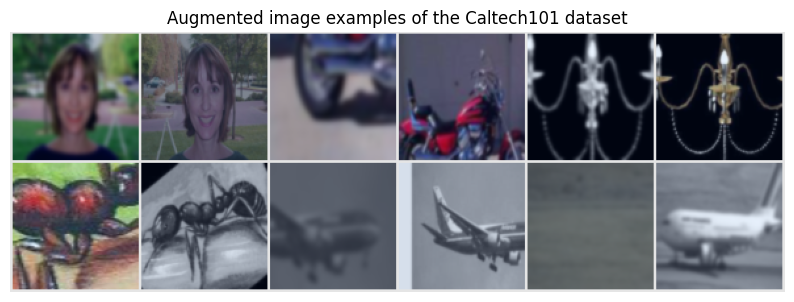

In [13]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6

images = torch.stack([image for idx in range(NUM_IMAGES) for image in train_data[idx][0]], dim=0)

img_grid = torchvision.utils.make_grid(images, nrow=6, normalize=True, pad_value=0.9)

img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Caltech101 dataset')
plt.imshow(img_grid,)
plt.axis('off')
plt.show()
plt.close()

In [14]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='valid')

In [15]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'simclr'),
                         accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'), LearningRateMonitor('epoch')])
    
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'simclr.ckpt')
    
    if os.path.isfile(pretrained_filename):        
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        # Dataloaders
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
        
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, valid_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [16]:
torch.set_float32_matmul_precision('medium')
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\james\anaconda3\envs\env_pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 11.5 M
-----------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Tota

Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir ./saved_models/tensorboards/simclr/